In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_rey_rot.zip to dataset_rey_rot.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_rey_rot.zip']), 'r')
data.extractall()

In [3]:
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image

In [4]:
train_path = '/content/dataset_rey_rot/train/' 
test_path = '/content/dataset_rey_rot/test/'
validation_path = '/content/dataset_rey_rot/val/'

In [5]:
classes = ['rot0', 'rot90','rot180','rot-90']

In [6]:
print('The training set consists of ', 
      classes[0] + ': ',
      len(os.listdir(train_path + classes[0] + '/')), ' images. ',
      classes[1] + ': ',
      len(os.listdir(train_path + classes[1] + '/')), ' images. ',
      classes[2] + ': ',
      len(os.listdir(train_path + classes[2] + '/')), ' images. ',
      classes[3] + ': ',
      len(os.listdir(train_path + classes[3] + '/')), ' images. '
      )

The training set consists of  rot0:  253  images.  rot90:  348  images.  rot180:  24  images.  rot-90:  83  images. 


In [7]:
print('The test set consists of ', 
      classes[0] + ': ',
      len(os.listdir(test_path + classes[0] + '/')), ' images. ',
      classes[1] + ': ',
      len(os.listdir(test_path + classes[1] + '/')), ' images. ',
      classes[2] + ': ',
      len(os.listdir(test_path + classes[2] + '/')), ' images. ',
      classes[3] + ': ',
      len(os.listdir(test_path + classes[3] + '/')), ' images. '
      )

The test set consists of  rot0:  33  images.  rot90:  44  images.  rot180:  3  images.  rot-90:  11  images. 


**-------------> VGG16 model <-------------**

In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot
from keras.callbacks import EarlyStopping

In [9]:
# define cnn model
def define_model():
  # load model
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  
  last_layer = model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(4, activation='softmax')(x)
  model = tf.keras.Model(model.input, x)  

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [10]:
model = define_model()
model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [12]:
X_val, y_val, labels = load_data(validation_path)

100%|██████████| 4/4 [00:00<00:00, 51.64it/s]

87 images loaded from /content/dataset_rey_rot/val/ directory.


In [13]:
import matplotlib.pyplot as plt
def plotHistory(history):
  N = np.arange(0, EPOCHS)
  plt.figure()
  plt.plot(N, history.history["loss"], label="train_loss")
  plt.plot(N, history.history["val_loss"], label="val_loss")
  plt.plot(N, history.history["accuracy"], label="train_acc")
  plt.plot(N, history.history["val_accuracy"], label="val_acc")
  plt.title("Training/Validation Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [14]:
EPOCHS = 60
def trainModel():
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1./255)
  train_it = datagen.flow_from_directory(train_path, batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory(test_path, batch_size=64, target_size=(224, 224))

  history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=EPOCHS, verbose=1)
  
  loss, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
  print('acc > %.3f' % (acc * 100.0))
  print("loss : ", loss)    
  
  plotHistory(history)

  return model

Found 708 images belonging to 4 classes.
Found 91 images belonging to 4 classes.
Epoch 1/60
12/12 [==============================] - 23s 624ms/step - loss: 1.2472 - accuracy: 0.5226 - val_loss: 0.8595 - val_accuracy: 0.6264
Epoch 2/60
12/12 [==============================] - 4s 315ms/step - loss: 0.8832 - accuracy: 0.6398 - val_loss: 0.6354 - val_accuracy: 0.7912
Epoch 3/60
12/12 [==============================] - 4s 318ms/step - loss: 0.6147 - accuracy: 0.7655 - val_loss: 0.4751 - val_accuracy: 0.8571
Epoch 4/60
12/12 [==============================] - 4s 324ms/step - loss: 0.4684 - accuracy: 0.8362 - val_loss: 0.4058 - val_accuracy: 0.8901
Epoch 5/60
12/12 [==============================] - 4s 320ms/step - loss: 0.4183 - accuracy: 0.8630 - val_loss: 0.3373 - val_accuracy: 0.8791
Epoch 6/60
12/12 [==============================] - 4s 315ms/step - loss: 0.3235 - accuracy: 0.9082 - val_loss: 0.3137 - val_accuracy: 0.8571
Epoch 7/60
12/12 [==============================] - 4s 328ms/step 

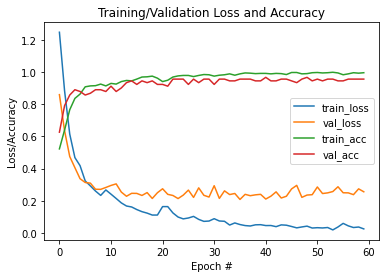

In [15]:
modelVgg = trainModel()